## Оксана Рудковская, MNIST

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_label.shape

(42000,)

In [5]:
train_img.shape

(42000, 28, 28)

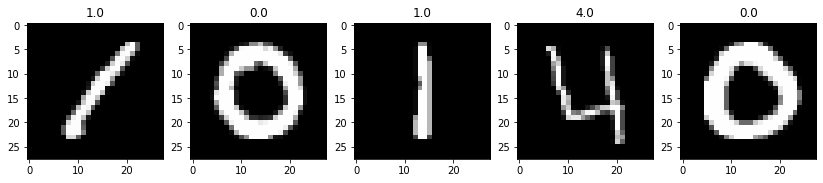

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1])

### PCA преобразование

In [7]:
# выбираем семпл данных для обработки
choices = np.random.choice(train_img.shape[0], 10000)
y = train_label[choices]
X = train_img[choices].reshape(-1, 28 * 28).astype(np.float32)

In [8]:
# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

In [9]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

In [10]:
U, S, _ = np.linalg.svd(cov)

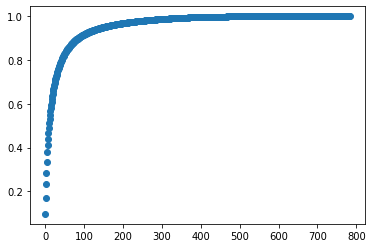

In [11]:
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [12]:
S_thr = 0.75  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=32 S=0.752


In [13]:
Xrot_reduced = np.dot(X, U[:, :n_comp])

### Random Forest Classifier

In [14]:
#Обучаем данные на случайном лесе
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(max_depth=20,min_samples_leaf=5,n_estimators=100,n_jobs=-1,random_state=42)

rfc.fit(Xrot_reduced,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [15]:
# Проверяем данные на валидационной выборке
y_val = train_label[[x for x in range(train_img.shape[0]) if x not in choices]]
X_val = train_img[[x for x in range(train_img.shape[0]) if x not in choices]].reshape(-1, 28 * 28).astype(np.float32)
X_val_mean = X_val.mean(axis=0)
X_val -= X_val_mean

In [16]:
# Проецируем на базовые вектора
X_val_reduced = np.dot(X_val, U[:, :n_comp])

In [17]:
y_pred_val = rfc.predict(X_val_reduced)
print('Accuracy: %s' % accuracy_score(y_val, y_pred_val))

Accuracy: 0.9161454083945245


In [18]:
# Готовим данные тестовой выборки
X_test = test_img.reshape(-1, 28 * 28).astype(np.float32)
X_test_mean = X_test.mean(axis=0)
X_test -= X_test_mean
X_test_reduced = np.dot(X_test, U[:, :n_comp])

In [19]:
y_pred_test = rfc.predict(X_test_reduced)

In [20]:
y_pred_test

array([2., 0., 9., ..., 3., 9., 2.])

### Готовим файл для отправки

In [21]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))